# AtlantOS transport arrays

Following http://www.oceansites.org/tma/index.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cmocean
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import xarray as xr

import warnings
import CM4Xutils
import sectionate as sec
import regionate as reg
import tosnap

import xbudget
import xwmb

In [4]:
path = "/work/hfd/codedev/CM4Xutils/data/coarsened/CM4Xp125_budgets_sigma2_2020-2024.zarr"
ds = xr.open_zarr(path)
grid = CM4Xutils.ds_to_grid(ds.fillna(0.))

Inferring Z grid coordinate: density `sigma2`


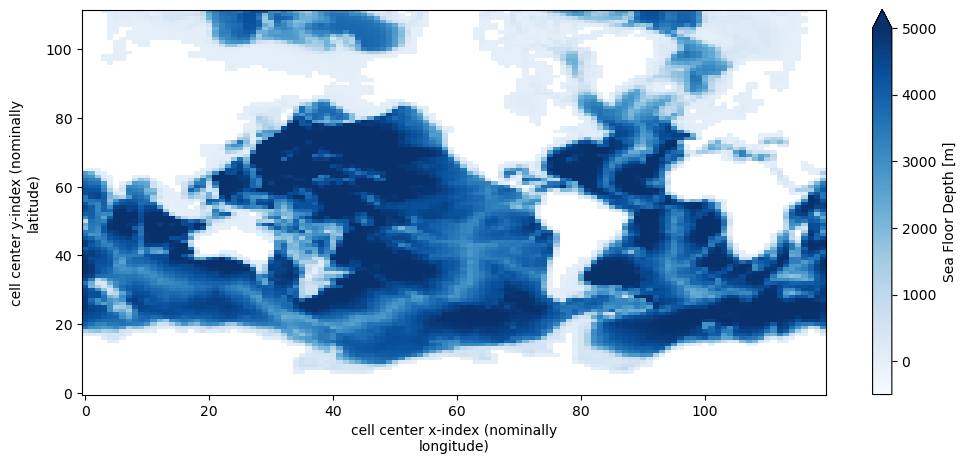

In [5]:
plt.figure(figsize=(12, 5))
grid._ds['deptho'].where(grid._ds['deptho']>0).plot(cmap="Blues", vmin=-500, vmax=5000)

In [6]:
sec1 = tosnap.atlantic_sections["Denmark Strait"]
sec2 = tosnap.atlantic_sections["Faroe Current"]
sec3 = tosnap.atlantic_sections["Faroe Bank"]

sec1, sec2, sec3

(Section(Denmark Strait, [(-44, 69), (-35, 69), (-25, 65), (-20, 65)]),
 Section(Faroe Current, [(-14.0, 65.0), (-6.25, 62.25)]),
 Section(Faroe Bank, [(-6.25, 62.25), (-6.25, 61.0), (-5.0, 58.5), (-5.0, 56.75)]))

In [7]:
section_test = sec.join_sections("Denmark Extended", sec1, sec2.reverse(), sec3)
section_test

Section(Denmark Extended, [(-44, 69), (-35, 69), (-25, 65), (-20, 65), (-14.0, 65.0), (-6.25, 62.25), (-6.25, 62.25), (-6.25, 61.0), (-5.0, 58.5), (-5.0, 56.75)])
 Children:
  - Section(Denmark Strait, [(-44, 69), (-35, 69), (-25, 65), (-20, 65)])
  - Section(Faroe Current, [(-14.0, 65.0), (-6.25, 62.25)])
  - Section(Faroe Bank, [(-6.25, 62.25), (-6.25, 61.0), (-5.0, 58.5), (-5.0, 56.75)])

In [9]:
atl = tosnap.grid_atlantic(grid)

In [10]:
atl.region_dict

{'South Atlantic': regionate.region.BoundedRegion("South Atlantic"),
 'Tropical Atlantic': regionate.region.BoundedRegion("Tropical Atlantic"),
 'Gulf of Mexico': regionate.region.BoundedRegion("Gulf of Mexico"),
 'Subtropical North Atlantic': regionate.region.BoundedRegion("Subtropical North Atlantic"),
 'Subpolar North Atlantic': regionate.region.BoundedRegion("Subpolar North Atlantic"),
 'Labrador Sea': regionate.region.BoundedRegion("Labrador Sea"),
 'Irminger Sea': regionate.region.BoundedRegion("Irminger Sea"),
 'Greenland Sea': regionate.region.BoundedRegion("Greenland Sea"),
 'High Arctic': regionate.region.BoundedRegion("High Arctic")}

In [325]:
for region_name, region in atl.region_dict.items():
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
    
        budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
        xbudget.collect_budgets(grid, budgets_dict)

        wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict,
            region
        )
        wmb.mass_budget("sigma2", default_bins=False, greater_than=True, along_section=True)
        region.save["wmt"] = wmb.wmt.drop_dims("time_bounds")
        region.save["wmt"].load()

        # Get transports across each child section
        for child_name, child in region.children.items():
            lons_sect, lats_sect = sec.uvcoords_from_qindices(grid, child.i, child.j)
            child_sect = xr.Dataset(
                {
                    "lon_sect": xr.DataArray(lons_sect, dims=("subsect",)),
                    "lat_sect": xr.DataArray(lats_sect, dims=("subsect",))
                },
                coords = {"subsect": xr.DataArray(np.arange(0,lons_sect.size), dims=("subsect",))}
            )

            dist = sec.distance_on_unit_sphere(
                wmb.grid._ds['convergent_mass_transport_along'].lon_sect,
                wmb.grid._ds['convergent_mass_transport_along'].lat_sect,
                child_sect.lon_sect,
                child_sect.lat_sect
            )
            
            child_mask = (dist <= 1.e3).any("subsect")
            child.save["wmt"] = (
                wmb.grid._ds[['convergent_mass_transport_along']]
                .where(child_mask).sum("sect")
            ).rename({"convergent_mass_transport_along":"convergent_mass_transport"})
            child.save["wmt"].load()

In [348]:
atl.to_grs("../data/")